In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [8]:
import os
import sys
import argparse
import datetime
import shutil
from pprint import pprint
from pathlib import Path

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torchvision
import numpy as np
from torch.utils.tensorboard import SummaryWriter

sys.path.insert(0, '../../../SimCLRv2-PyTorch/')

from utils.model import save_model, load_optimizer
from simclr.modules import LogisticRegression
from simclr import SimCLRv2, SimCLRv2_ft
from simclr.modules import get_resnet, NT_Xent
from simclr.modules.transformations import TransformsSimCLR
from utils import yaml_config_hook
from utils.img_dataset_utils import *

In [3]:
simclr_repo = Path('/home/kaipak/dev/SimCLRv2-PyTorch/')
parser = argparse.ArgumentParser(description="SimCLR")
config = yaml_config_hook('simclrv2_config_marsv2.yaml')
tb_out = Path('/home/kaipak/models/tensorboard_logs')

for k, v in config.items():
    parser.add_argument(f"--{k}", default=v, type=type(v))
    
args = parser.parse_args([])
args.device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [4]:
config

{'nodes': 1,
 'gpus': 4,
 'nr': 0,
 'dataparallel': 0,
 'workers': 32,
 'dataset_dir': '/home/kaipak/datasets',
 'seed': 42,
 'batch_size': 128,
 'image_size': 224,
 'start_epoch': 0,
 'epochs': 100,
 'pretrain': True,
 'optimizer': 'LARS',
 'weight_decay': 1e-06,
 'temperature': 0.5,
 'model_path': '/home/kaipak/models/SimCLRv2/save',
 'epoch_num': 100,
 'reload': False}

# Data
Data collected from Zenodo: https://zenodo.org/record/4033453

In [28]:
# Set up some data structures we'll need
def text2df(filename, sep=r'\s+', names=['img', 'label'], df_desc=None, label_set=None, drop_other=False):
  """Get dataframes from label text"""
  df = pd.read_csv(filename, sep=sep, header=None, names=names, index_col=None, engine='python')
  if df_desc is not None:
    df = pd.merge(df, df_desc, on='label', how="left", sort=False)
  if label_set is not None:
    df['label_set'] = label_set
    df['img'] = df['img'].str.replace('calibrated/', '')
  if drop_other:
    df = df.loc[~df.label_desc.isin(["Other rover part", "Artifact"])]
  return df

def sumarize(df, proportion=True):
  """Sumamry proportion of datasets"""
  
  if proportion:
    df_sum = df.groupby(by=['label_desc']).size().to_frame(name="proportion")
    df_sum['proportion'] /= df.shape[0]
  else:
    df_sum = df.groupby(by=['label_desc']).size().to_frame(name="count")
  return df_sum.reset_index()

In [29]:
BASE_PATH = Path('/home/kaipak/datasets/msl-labeled-data-set-v2.1/')
BASE_IMG_PATH = BASE_PATH / 'images'
PROC_IMG_PATH = Path('/home/kaipak/datasets/msl-labeled-data-set-v2.1-processed')

IMG_ALL      = Path(BASE_IMG_PATH)
LABEL_DESC   = pd.read_csv(f'{BASE_PATH}/class_map.csv', names=['label', 'label_desc'])
TEST_LABELS  = text2df(f'{BASE_PATH}/test-set-v2.1.txt', df_desc=LABEL_DESC, label_set="test")
TRAIN_LABELS = text2df(f'{BASE_PATH}/train-set-v2.1.txt', df_desc=LABEL_DESC, label_set="train")
VAL_LABELS   = text2df(f'{BASE_PATH}/val-set-v2.1.txt', df_desc=LABEL_DESC, label_set="validation")
ALL_LABELS   = pd.concat([TEST_LABELS, TRAIN_LABELS, VAL_LABELS])

In [28]:
TRAIN_LABELS.head()

,img,label,label_desc,label_set
0,0042MR0001830110101823Q01_DRCL.jpg,2,Artifact,train
1,0042MR0001830110101823Q01_DRCL-fh.jpg,2,Artifact,train
2,0442MH0001520020200158I01_DRCL.jpg,4,Close-up rock,train
3,0442MH0001520020200158I01_DRCL-r90.jpg,4,Close-up rock,train
4,0442MH0001520020200158I01_DRCL-r180.jpg,4,Close-up rock,train


In [29]:
print(f'Train dataset size: {TRAIN_LABELS.shape[0]}')
print(f'Val dataset size: {VAL_LABELS.shape[0]}')
print(f'Test dataset size: {TEST_LABELS.shape[0]}')
LABEL_DESC

Train dataset size: 5920
Val dataset size: 300
Test dataset size: 600


,label,label_desc
0,0,Arm cover
1,1,Other rover part
2,2,Artifact
3,3,Nearby surface
4,4,Close-up rock
5,5,DRT
6,6,DRT spot
7,7,Distant landscape
8,8,Drill hole
9,9,Night sky


In [35]:
# MSL Dataset Generator 
BASE_DIR = Path('/home/kaipak/datasets/msl-v2.1-full')
for dataset, df_set in {'train': TRAIN_LABELS, 
                        'validation': VAL_LABELS, 
                        'test': TEST_LABELS}.items():
    dest_path = BASE_DIR / dataset
    if dest_path.exists() and dest_path.is_dir():
        shutil.rmtree(dest_path)
    dest_path.mkdir(parents=True, exist_ok=True)
    print(dest_path)
    
    # Make directories for all images
    for label in LABEL_DESC.label_desc:
        (dest_path / label).mkdir()
    
    for i, row in df_set.iterrows():
        shutil.copy(BASE_IMG_PATH / row.img, dest_path / row.label_desc)

/home/kaipak/datasets/msl-v2.1-full/train
/home/kaipak/datasets/msl-v2.1-full/validation
/home/kaipak/datasets/msl-v2.1-full/test


In [5]:
bs = 64

train_images = torchvision.datasets.ImageFolder('/home/kaipak/datasets/msl-v2.1-full/train',
                                                transform=TransformsSimCLR(size=args.image_size).test_transform)
valid_images = torchvision.datasets.ImageFolder('/home/kaipak/datasets/msl-v2.1-full/validation',
                                                transform=TransformsSimCLR(size=args.image_size).test_transform)
test_images = torchvision.datasets.ImageFolder('/home/kaipak/datasets/msl-v2.1-full/test', 
                                               transform=TransformsSimCLR(size=args.image_size).test_transform)
train_loader = torch.utils.data.DataLoader(train_images, batch_size=bs, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_images, batch_size=bs, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_images, batch_size=bs, shuffle=True)

In [13]:
len(train_loader.dataset.classes)

19

# Model

In [18]:
n_classes = len(train_loader.dataset.classes)
simclr_model = SimCLRv2(resnet_depth=50, resnet_width_multiplier=2, sk_ratio=0.0625, 
                        pretrained_weights='/home/kaipak/models/SimCLRv2/r50_2x_sk1.pth')
simclr_model_ft = SimCLRv2_ft(simclr_model, n_classes)

if torch.cuda.device_count() > 1:
  print("Let's use", torch.cuda.device_count(), "GPUs!")
  simclr_model_ngpu = nn.DataParallel(simclr_model_ft)

simclr_model = simclr_model_ngpu.to(args.device)

Let's use 4 GPUs!


In [19]:
simclr_model.load_state_dict(torch.load('kai_model.pt'))

<All keys matched successfully>

In [16]:
def train(args, loader, model, criterion, optimizer, writer):
    """Train evaluation model"""
    epoch_loss = 0
    epoch_accuracy = 0
    model.train()
    
    for step, input in enumerate(loader):
        optimizer.zero_grad()
        X, y = input
        X = X.cuda(non_blocking=True)
        y = y.cuda(non_blocking=True)
        
        output = model(X)
        step_loss = criterion(output, y)
        
        predicted = output.argmax(1)
        step_accuracy = (predicted == y).sum().item() / y.size(0)
        epoch_accuracy += step_accuracy
        
        step_loss.backward()
        optimizer.step()
        
        epoch_loss += step_loss
        writer.add_scalar("Accuracy/train_step", step_accuracy, args.global_step)
        args.global_step += 1
        
        if step % 100 == 0:
            print(f"Step [{step}/{len(loader)}]\t Accuracy {step_accuracy}...")
        
    writer.add_scalar("Accuracy/train_epoch", step_accuracy, args.current_epoch)
    writer.add_scalar("Loss/train_epoch", epoch_loss, args.current_epoch)

    return epoch_loss, epoch_accuracy

def test(args, loader, model, criterion, optimizer):
    epoch_loss = 0
    epoch_accuracy = 0
    model.eval()
    
    for step, (x, y) in enumerate(loader):
        model.zero_grad()
        
        x = x.to(args.device)
        y = y.to(args.device)
        
        output = model(x)
        step_loss = criterion(output, y)
        
        predicted = output.argmax(1)
        step_accuracy = (predicted == y).sum().item() / y.size(0)
        epoch_accuracy += step_accuracy
        
        epoch_loss += step_loss.item()
    
    return epoch_loss, epoch_accuracy

In [20]:
optimizer, scheduler = load_optimizer(args, simclr_model)
criterion = torch.nn.CrossEntropyLoss()
writer = SummaryWriter(log_dir='/home/kaipak/models/runs')

2021-10-04 18:12:16.151879: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.2
2021-10-04 18:12:17.086289: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer.so.7
2021-10-04 18:12:17.086429: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer_plugin.so.7


In [59]:
%time
args.global_step = 0
args.current_epoch = 0
args.logistic_epochs = 3
tb_writer =  SummaryWriter(log_dir=f'/home/kaipak/models/tensorboard_logs/' +
                           f'{datetime.now().strftime("%Y%m%d-%H%M%S")}')

#for epoch in range(args.logistic_epochs):
for epoch in range(args.logistic_epochs):
    loss_epoch, accuracy_epoch = train(args, train_loader, simclr_model, criterion, optimizer, tb_writer)
    
    print(f"Epoch [{epoch}/{args.logistic_epochs}]\t Loss: {loss_epoch / len(train_loader)}\t Accuracy: {accuracy_epoch / len(train_loader)}")
    
    args.current_epoch += 1

loss_epoch, accuracy_epoch = test(
    args, test_loader, simclr_model, criterion, optimizer
)

print(
    f"[FINAL]\t Loss: {loss_epoch / len(test_loader)}\t Accuracy: {accuracy_epoch / len(test_loader)}"
)

CPU times: user 8 µs, sys: 1 µs, total: 9 µs
Wall time: 18.4 µs
Step [0/93]	 Accuracy 0.0...
Epoch [0/3]	 Loss: 1.0710080862045288	 Accuracy: 0.7054771505376344
Step [0/93]	 Accuracy 0.890625...
Epoch [1/3]	 Loss: 0.27717193961143494	 Accuracy: 0.913138440860215
Step [0/93]	 Accuracy 0.953125...
Epoch [2/3]	 Loss: 0.13093070685863495	 Accuracy: 0.9566532258064516
[FINAL]	 Loss: 0.7342144995927811	 Accuracy: 0.8239583333333333


In [78]:
args.model_path = '~'

In [81]:
torch.save(simclr_model.state_dict(), 'kai_model.pt')

In [21]:
preds = []
y_true = []

for step, (x, y) in enumerate(test_loader):
    simclr_model.zero_grad()
    
    x = x.to(args.device)
    y = y.to(args.device)
    y_true.extend(y.tolist())
    
    output = simclr_model(x)
    pred = output.argmax(1)
    preds.extend(pred.tolist())
     

In [22]:
torch.cuda.empty_cache()

In [24]:
preds == y_true

False

<AxesSubplot:>

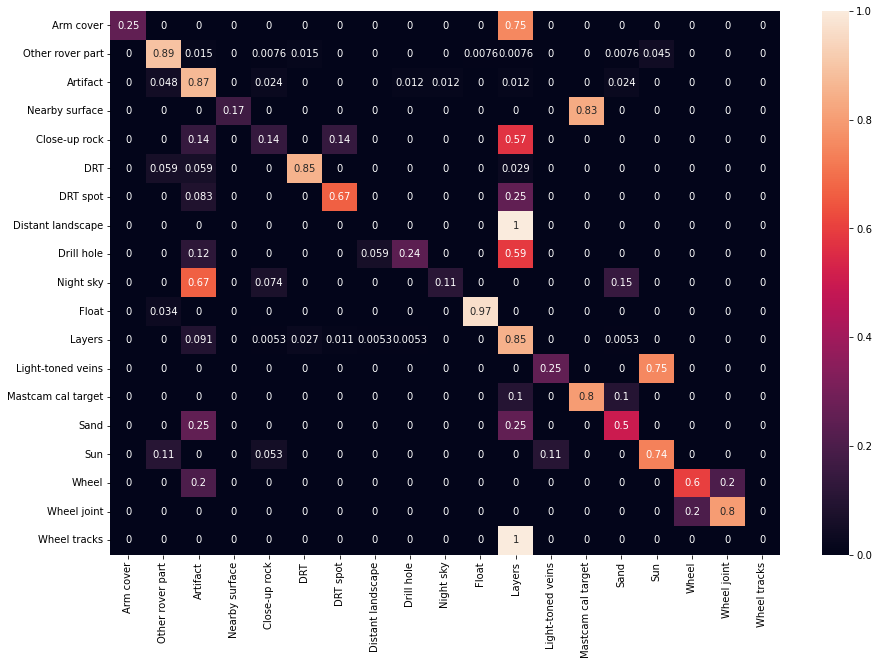

In [43]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import classification_report

fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(pd.DataFrame(confusion_matrix(y_true, preds, normalize='true'), 
                         LABEL_DESC.loc[LABEL_DESC.label.isin(y_true)].label_desc.values, 
                         LABEL_DESC.loc[LABEL_DESC.label.isin(y_true)].label_desc.values), annot=True, ax=ax)

In [42]:
print(classification_report(y_true, preds, target_names=LABEL_DESC.loc[LABEL_DESC.label.isin(y_true)].label_desc.values))

                    precision    recall  f1-score   support

         Arm cover       1.00      0.25      0.40         4
  Other rover part       0.93      0.89      0.91       132
          Artifact       0.60      0.87      0.71        84
    Nearby surface       1.00      0.17      0.29         6
     Close-up rock       0.12      0.14      0.13         7
               DRT       0.81      0.85      0.83        34
          DRT spot       0.73      0.67      0.70        12
 Distant landscape       0.00      0.00      0.00         1
        Drill hole       0.67      0.24      0.35        17
         Night sky       0.75      0.11      0.19        27
             Float       0.97      0.97      0.97        29
            Layers       0.84      0.85      0.85       187
 Light-toned veins       0.33      0.25      0.29         4
Mastcam cal target       0.62      0.80      0.70        10
              Sand       0.47      0.50      0.48        16
               Sun       0.61      0.74

/home/kaipak/miniconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/kaipak/miniconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/kaipak/miniconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

In [41]:
LABEL_DESC.loc[LABEL_DESC.label.isin(y_true)].label_desc.values

array(['Arm cover', 'Other rover part', 'Artifact', 'Nearby surface',
       'Close-up rock', 'DRT', 'DRT spot', 'Distant landscape',
       'Drill hole', 'Night sky', 'Float', 'Layers', 'Light-toned veins',
       'Mastcam cal target', 'Sand', 'Sun', 'Wheel', 'Wheel joint',
       'Wheel tracks'], dtype=object)